# Scan Results Analysis

Compares scanner outputs across all runs in `core_bench/scan-results/`, with a focus on **validation agreement** — how well the scanner's numeric predictions match the hand-labeled targets stored in each `_scan.json`.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from inspect_scout import scan_results_df

SCAN_ROOT = Path("scan-results")

## 1. Load all scans

In [2]:
scan_dirs = sorted(SCAN_ROOT.glob("scan_id=*"))

scan_meta = []
scan_dfs  = {}   # {scan_id: {scanner_name: df}}

for d in scan_dirs:
    scan_id = d.name.split("=", 1)[1]
    meta = json.loads((d / "_scan.json").read_text())
    scan_meta.append({
        "scan_id":    scan_id,
        "timestamp":  meta["timestamp"],
        "model":      meta["model"]["model"],
        "scanners":   list(meta["scanners"].keys()),
        "has_validation": list(meta.get("validation", {}).keys()),
    })
    r = scan_results_df(str(d))
    scan_dfs[scan_id] = r.scanners

meta_df = pd.DataFrame(scan_meta).sort_values("timestamp").reset_index(drop=True)
meta_df

,scan_id,timestamp,model,scanners,has_validation
0,WA5oTav6G3urEUqdFWwijL,2026-02-27T13:42:15.762353-07:00,openai/gpt-5-mini-2025-08-07,"[answer_format, command_not_found]",[]
1,bEiv4f9xi3Kp4VNYo9a9wJ,2026-02-27T15:51:33.010220-07:00,openai/gpt-5-mini-2025-08-07,"[answer_format, command_not_found]",[answer_format]
2,MtYqfm6WsFgCXznaXSbjpG,2026-02-27T16:11:56.991604-07:00,openai/gpt-5-mini-2025-08-07,"[answer_format, command_not_found]",[answer_format]


## 2. Combine all scanner results into one DataFrame

In [3]:
all_rows = []
for scan_id, scanners in scan_dfs.items():
    for scanner_name, df in scanners.items():
        all_rows.append(df)

combined = pd.concat(all_rows, ignore_index=True)

# Cast answer to float for numeric scanners
combined["answer_float"] = pd.to_numeric(combined["answer"], errors="coerce")
# validation_result as bool
combined["valid"] = combined["validation_result"] == "true"

print(f"Total rows: {len(combined)}")
print("Scanner names:", combined["scanner_name"].unique().tolist())
combined[["scan_id", "scanner_name", "transcript_id", "answer_float",
          "validation_target", "validation_result"]].head(8)

Total rows: 135
Scanner names: ['answer_format']


/tmp/ipykernel_166645/2968318456.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(all_rows, ignore_index=True)


,scan_id,scanner_name,transcript_id,answer_float,validation_target,validation_result
0,MtYqfm6WsFgCXznaXSbjpG,answer_format,2HMRtkCxgju7q87nBz5Msm,1.0,1,true
1,MtYqfm6WsFgCXznaXSbjpG,answer_format,2grUTB3MXmZJW3QcxUKygu,0.0,0,true
2,MtYqfm6WsFgCXznaXSbjpG,answer_format,4LWaZXamgv9M6GVrA78zgv,0.0,1,false
3,MtYqfm6WsFgCXznaXSbjpG,answer_format,5QHujhrnsNuSEfThXSukZi,0.0,1,false
4,MtYqfm6WsFgCXznaXSbjpG,answer_format,86R7tfNjB4UxNEbT2FXva2,1.0,3,false
5,MtYqfm6WsFgCXznaXSbjpG,answer_format,AGLCdV4EYk534irmHdooSr,1.0,1,true
6,MtYqfm6WsFgCXznaXSbjpG,answer_format,CqFpbjm5SccfTZrJjHkVvz,1.0,1,true
7,MtYqfm6WsFgCXznaXSbjpG,answer_format,DUEv7y7yeLCCShLw8YjEhS,0.0,0,true


## 3. Validation overview per scan × scanner

In [4]:
# Only rows that have a validation target
val = combined.dropna(subset=["validation_target"]).copy()
val["validation_target"] = pd.to_numeric(val["validation_target"], errors="coerce")

summary = (
    val.groupby(["scan_id", "scanner_name"])
    .agg(
        n_validated=("valid", "count"),
        n_correct=("valid", "sum"),
    )
    .assign(accuracy=lambda x: x["n_correct"] / x["n_validated"])
    .reset_index()
)
summary

,scan_id,scanner_name,n_validated,n_correct,accuracy
0,MtYqfm6WsFgCXznaXSbjpG,answer_format,45,35,0.777778
1,bEiv4f9xi3Kp4VNYo9a9wJ,answer_format,45,31,0.688889


## 4. Scanner answer vs. validation target — scatter / strip plot

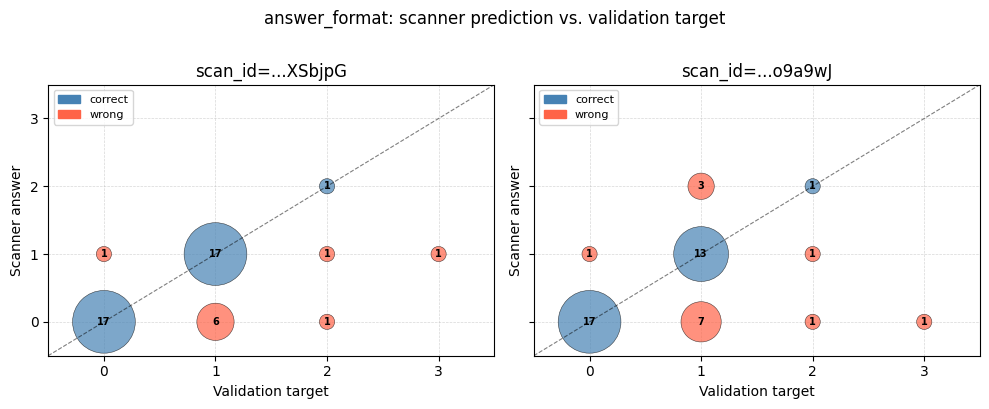

In [14]:
# Focus on answer_format scanner which has numeric targets
from matplotlib.patches import Patch

af = val[val["scanner_name"] == "answer_format"].copy()

fig, axes = plt.subplots(1, len(af["scan_id"].unique()), figsize=(5 * len(af["scan_id"].unique()), 4), sharey=True)
if not hasattr(axes, "__iter__"):
    axes = [axes]

for ax, (sid, grp) in zip(axes, af.groupby("scan_id")):
    counts = grp.groupby(["validation_target", "answer_float", "valid"]).size().reset_index(name="n")

    colors = counts["valid"].map({True: "steelblue", False: "tomato"})
    ax.scatter(counts["validation_target"], counts["answer_float"],
               c=colors, s=counts["n"] * 120, alpha=0.7, edgecolors="k", linewidths=0.4)

    for _, row in counts.iterrows():
        ax.text(row["validation_target"], row["answer_float"], str(int(row["n"])),
                ha="center", va="center", fontsize=7, fontweight="bold", color="black")

    lim = [-0.5, 3.5]
    ax.plot(lim, lim, "k--", lw=0.8, alpha=0.5)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticks([0, 1, 2, 3]); ax.set_yticks([0, 1, 2, 3])
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel("Validation target"); ax.set_ylabel("Scanner answer")
    ax.set_title(f"scan_id=...{sid[-6:]}")
    ax.legend(handles=[Patch(color="steelblue", label="correct"), Patch(color="tomato", label="wrong")], fontsize=8)

fig.suptitle("answer_format: scanner prediction vs. validation target", y=1.01)
plt.tight_layout()
plt.show()


## 5. Confusion matrix (answer_format, latest scan with validation)

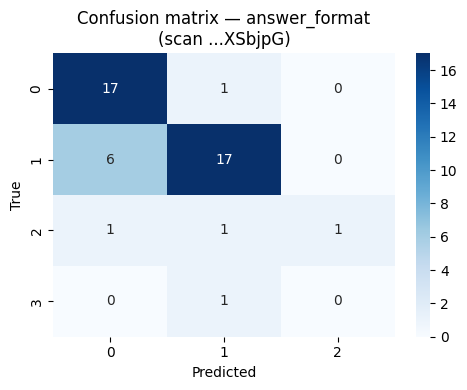

       support  precision  recall     f1
label                                   
0           18      0.708   0.944  0.810
1           23      0.850   0.739  0.791
2            3      1.000   0.333  0.500
3            1        NaN   0.000    NaN

Overall accuracy: 0.778


In [6]:
# Use the scan with the most validation entries
best_scan = summary[summary["scanner_name"] == "answer_format"].sort_values("n_validated", ascending=False).iloc[0]["scan_id"]
grp = af[af["scan_id"] == best_scan].dropna(subset=["answer_float", "validation_target"])

y_true = grp["validation_target"].astype(int)
y_pred = grp["answer_float"].round().astype(int)

cm = pd.crosstab(y_true, y_pred, rownames=["True"], colnames=["Predicted"])

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title(f"Confusion matrix — answer_format\n(scan ...{best_scan[-6:]})")
plt.tight_layout()
plt.show()

# Per-class precision/recall computed manually
labels = sorted(set(y_true) | set(y_pred))
rows = []
for lbl in labels:
    tp = ((y_true == lbl) & (y_pred == lbl)).sum()
    fp = ((y_true != lbl) & (y_pred == lbl)).sum()
    fn = ((y_true == lbl) & (y_pred != lbl)).sum()
    prec = tp / (tp + fp) if (tp + fp) else float("nan")
    rec  = tp / (tp + fn) if (tp + fn) else float("nan")
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else float("nan")
    rows.append({"label": lbl, "support": int((y_true == lbl).sum()),
                 "precision": round(prec, 3), "recall": round(rec, 3), "f1": round(f1, 3)})
report = pd.DataFrame(rows).set_index("label")
print(report)
print(f"\nOverall accuracy: {(y_true == y_pred).mean():.3f}")

## 6. Validation accuracy vs. transcript outcome

Do scanner errors cluster on transcripts where the agent succeeded (`C`) or failed (`I`)?

valid             scanner wrong  scanner correct  accuracy
transcript_score                                          
C                             6               26  0.812500
I                             4                9  0.692308


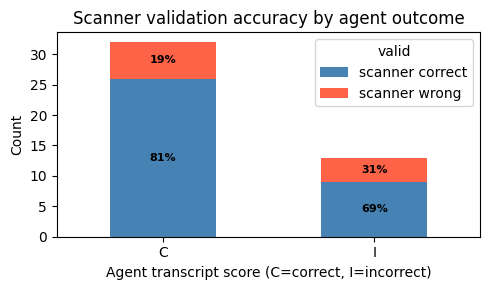

In [16]:
af_best = af[af["scan_id"] == best_scan].copy()

cross = (
    af_best.groupby(["transcript_score", "valid"])
    .size()
    .unstack("valid", fill_value=0)
    .rename(columns={True: "scanner correct", False: "scanner wrong"})
)
cross["accuracy"] = cross["scanner correct"] / (cross["scanner correct"] + cross["scanner wrong"])
print(cross)

cols = ["scanner correct", "scanner wrong"]
totals = cross[cols].sum(axis=1)

ax = cross[cols].plot(
    kind="bar", stacked=True, color=["steelblue", "tomato"],
    figsize=(5, 3), title="Scanner validation accuracy by agent outcome",
    xlabel="Agent transcript score (C=correct, I=incorrect)",
    ylabel="Count"
)

n_groups = len(cross)
for col_idx, col in enumerate(cols):
    for bar_idx in range(n_groups):
        patch = ax.patches[col_idx * n_groups + bar_idx]
        height = patch.get_height()
        if height == 0:
            continue
        pct = height / totals.iloc[bar_idx] * 100
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + height / 2
        ax.text(x, y, f"{pct:.0f}%", ha="center", va="center",
                fontsize=8, fontweight="bold", color="black")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 7. Multi-scan comparison — accuracy over time

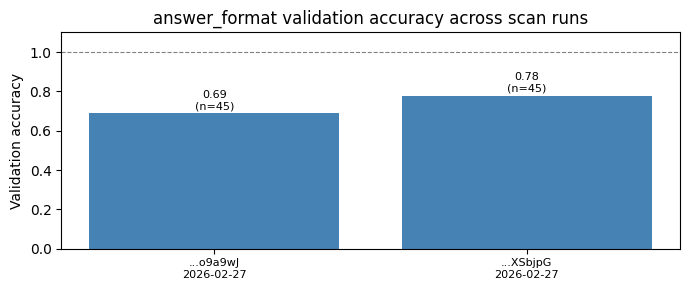

In [8]:
ts_map = meta_df.set_index("scan_id")["timestamp"]
plot_data = (
    summary[summary["scanner_name"] == "answer_format"]
    .assign(timestamp=lambda x: x["scan_id"].map(ts_map))
    .sort_values("timestamp")
)

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(range(len(plot_data)), plot_data["accuracy"], color="steelblue")
ax.set_xticks(range(len(plot_data)))
ax.set_xticklabels([f"...{sid[-6:]}\n{ts[:10]}" for sid, ts in zip(plot_data["scan_id"], plot_data["timestamp"])], fontsize=8)
ax.axhline(1.0, color="gray", linestyle="--", lw=0.8)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Validation accuracy")
ax.set_title("answer_format validation accuracy across scan runs")
for i, (acc, n) in enumerate(zip(plot_data["accuracy"], plot_data["n_validated"])):
    ax.text(i, acc + 0.02, f"{acc:.2f}\n(n={n})", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

## 8. Error analysis — which transcripts are consistently mis-predicted?

In [9]:
# All answer_format rows with validation
error_rows = af[~af["valid"]].copy()
error_rows["error"] = error_rows["answer_float"].round().astype("Int64").astype(str) + " → " + error_rows["validation_target"].astype("Int64").astype(str)

# Count how many scans each transcript fails in
fail_counts = (
    error_rows.groupby("transcript_id")
    .agg(
        fail_in_n_scans=("scan_id", "nunique"),
        errors=("error", lambda x: ", ".join(sorted(set(x)))),
        transcript_score=("transcript_score", "first"),
        validation_target=("validation_target", "first"),
    )
    .sort_values("fail_in_n_scans", ascending=False)
    .reset_index()
)
fail_counts

,transcript_id,fail_in_n_scans,errors,transcript_score,validation_target
0,5QHujhrnsNuSEfThXSukZi,2,0 → 1,I,1
1,Tt52fohUr3Ee6GueoLh5qU,2,0 → 1,I,1
2,86R7tfNjB4UxNEbT2FXva2,2,"0 → 3, 1 → 3",I,3
3,P8ZoZMjnNRJ6Zw9PCHBmfZ,2,0 → 1,C,1
4,NN9A9EPm6Eqq7WpB4yj2x8,2,0 → 1,C,1
5,oCZTiRG24F6vm3cLuZAt6x,2,1 → 2,I,2
6,YeMcaRCoKeqcsyhA3sgXfE,2,0 → 2,C,2
7,2HMRtkCxgju7q87nBz5Msm,1,0 → 1,C,1
8,4LWaZXamgv9M6GVrA78zgv,1,0 → 1,C,1
9,PwzLRemUujUX88trLVdaZr,1,0 → 1,C,1


# 9. Comparing the impact of switching to binary scoring


/tmp/ipykernel_166645/1261045049.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(all_rows, ignore_index=True)


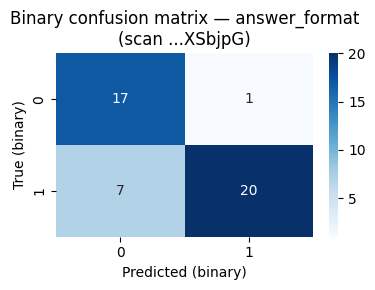


scan_id=...XSbjpG
       support  precision  recall     f1
label                                   
0           18      0.708   0.944  0.810
1           27      0.952   0.741  0.833
Overall accuracy: 0.822  (n=45)


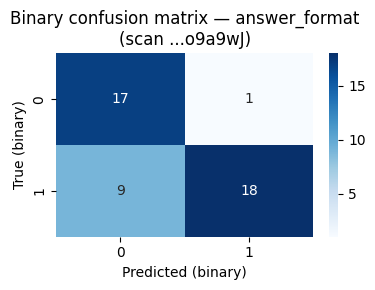


scan_id=...o9a9wJ
       support  precision  recall     f1
label                                   
0           18      0.654   0.944  0.773
1           27      0.947   0.667  0.783
Overall accuracy: 0.778  (n=45)


In [22]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from inspect_scout import scan_results_df

SCAN_ROOT = Path("scan-results")

# ── Load all scans ────────────────────────────────────────────────────────────
scan_dirs = sorted(SCAN_ROOT.glob("scan_id=*"))

scan_meta = []
scan_dfs  = {}

for d in scan_dirs:
    scan_id = d.name.split("=", 1)[1]
    meta = json.loads((d / "_scan.json").read_text())
    scan_meta.append({"scan_id": scan_id, "timestamp": meta["timestamp"]})
    r = scan_results_df(str(d))
    scan_dfs[scan_id] = r.scanners

meta_df = pd.DataFrame(scan_meta).sort_values("timestamp").reset_index(drop=True)

# ── Combine ───────────────────────────────────────────────────────────────────
all_rows = []
for scan_id, scanners in scan_dfs.items():
    for scanner_name, df in scanners.items():
        all_rows.append(df)

combined = pd.concat(all_rows, ignore_index=True)
combined["answer_float"] = pd.to_numeric(combined["answer"], errors="coerce")

# ── Binary transform: 0 stays 0, >0 → 1 ──────────────────────────────────────
af = combined[combined["scanner_name"] == "answer_format"].copy()
af = af.dropna(subset=["answer_float", "validation_target"])
af["validation_target"] = pd.to_numeric(af["validation_target"], errors="coerce")
af = af.dropna(subset=["validation_target"])

af["y_pred_bin"] = (af["answer_float"] > 0).astype(int)
af["y_true_bin"] = (af["validation_target"] > 0).astype(int)
af["valid_bin"]  = af["y_pred_bin"] == af["y_true_bin"]

# ── Per-scan confusion matrix + stats ────────────────────────────────────────
for scan_id, grp in af.groupby("scan_id"):
    y_true = grp["y_true_bin"]
    y_pred = grp["y_pred_bin"]

    cm = pd.crosstab(y_true, y_pred, rownames=["True (binary)"], colnames=["Predicted (binary)"])

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Binary confusion matrix — answer_format\n(scan ...{scan_id[-6:]})")
    plt.tight_layout()
    plt.show()

    # Per-class precision / recall / F1
    rows = []
    for lbl in [0, 1]:
        tp = ((y_true == lbl) & (y_pred == lbl)).sum()
        fp = ((y_true != lbl) & (y_pred == lbl)).sum()
        fn = ((y_true == lbl) & (y_pred != lbl)).sum()
        prec = tp / (tp + fp) if (tp + fp) else float("nan")
        rec  = tp / (tp + fn) if (tp + fn) else float("nan")
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else float("nan")
        rows.append({
            "label":     lbl,
            "support":   int((y_true == lbl).sum()),
            "precision": round(prec, 3),
            "recall":    round(rec, 3),
            "f1":        round(f1, 3),
        })
    report = pd.DataFrame(rows).set_index("label")
    print(f"\nscan_id=...{scan_id[-6:]}")
    print(report)
    print(f"Overall accuracy: {(y_true == y_pred).mean():.3f}  (n={len(y_true)})")
